In [1]:
# !pip3 install gymnasium

In [2]:
# import gymnasium as gyms

In [4]:
import random

tasks = {
    "easy": {"probability": 1.0, "payoff": 1},
    "medium": {"probability": 0.7, "payoff": 3},
    "hard": {"probability": 0.3, "payoff": 6}
}

game_configs = {
    "basic": {"easy": 4, "medium": 1, "hard": 1},
    "intermediate": {"easy": 2, "medium": 2, "hard": 2},
    "hard": {"easy": 1, "medium": 1, "hard": 4}
}

def generate_tasks(game_type, volume_level):
    config = game_configs[game_type]
    task_list = []
    for task_type, count in config.items():
        task_list.extend([task_type] * count * volume_level)
    random.shuffle(task_list)
    return task_list

def simulate_game(task_list, strategy_func_1, strategy_func_2):
    scores = [0, 0]

    for player_id, strategy_func in enumerate([strategy_func_1, strategy_func_2], start=1):
        for task in task_list:
            if task is None:
                continue

            attempt = strategy_func(task, scores[player_id - 1])

            if attempt:
                if random.random() <= tasks[task]["probability"]:
                    scores[player_id - 1] += tasks[task]["payoff"]
                task_list[task_list.index(task)] = None

    return scores

def risk_averse(task, current_score):
    return task == "easy"

def opportunistic_strategy(task, current_score):
    return task == "hard"

def random_strategy(task, current_score):
    return random.choice([True, False])

task_list = generate_tasks("basic", 1)

scores = simulate_game(task_list, risk_averse, opportunistic_strategy)
print(f"Final Scores: Player 1 = {scores[0]}, Player 2 = {scores[1]}")


Final Scores: Player 1 = 4, Player 2 = 6


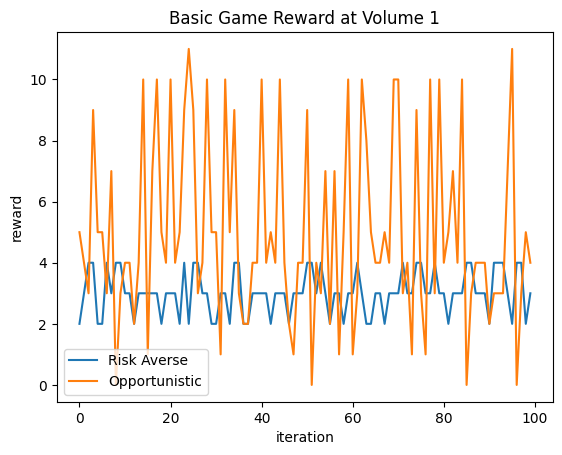

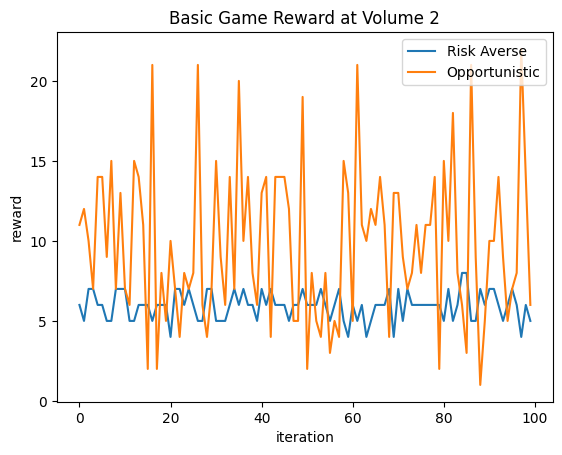

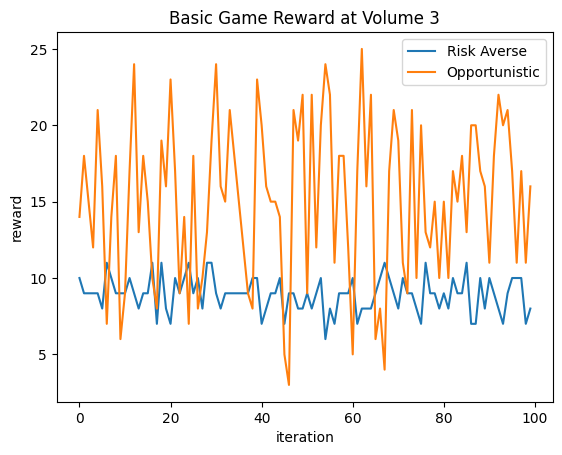

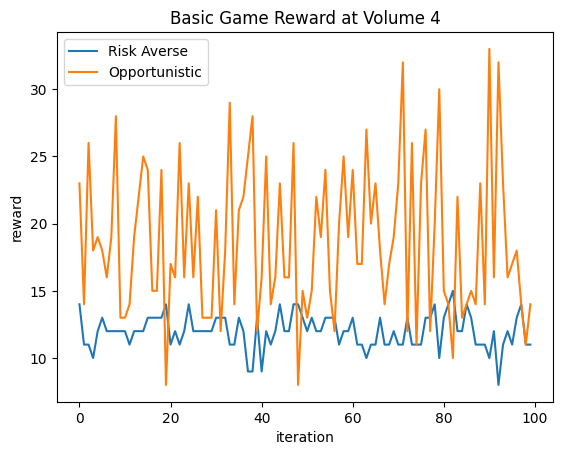

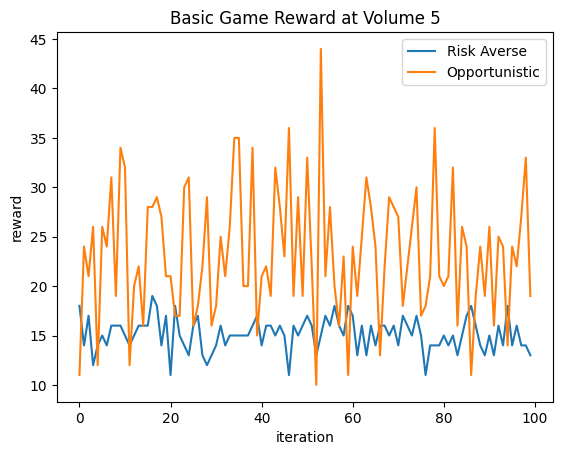

In [50]:
import random
import matplotlib.pyplot as plt
import numpy as np

tasks = {
    "easy": {"probability": 1.0, "payoff": 1},
    "medium": {"probability": 0.7, "payoff": 3},
    "hard": {"probability": 0.3, "payoff": 6}
}

game_configs = {
    "basic": {"easy": 4, "medium": 1, "hard": 1},
    "intermediate": {"easy": 2, "medium": 2, "hard": 2},
    "hard": {"easy": 1, "medium": 1, "hard": 4}
}

def generate_tasks(game_type, volume_level):
    config = game_configs[game_type]
    task_list = []
    for task_type, count in config.items():
        task_list.extend([task_type] * count * volume_level)
    random.shuffle(task_list)
    return task_list

def simulate_game(task_list, strategy_func_1, strategy_func_2):
    scores = [0, 0]
    remaining_tasks = task_list.copy()
    action_history = {1: [], 2: []}  # This dictionary will store the action history for both players

    while remaining_tasks:
        chosen_tasks = [strategy_func_1(remaining_tasks, scores[0]),
                        strategy_func_2(remaining_tasks, scores[1])]

        # If both players choose the same task, decide who gets it with a coin flip
        if chosen_tasks[0] == chosen_tasks[1] and chosen_tasks[0] is not None:
            winner = random.choice([0, 1])
            other = 1 - winner
            success = random.random() <= tasks[chosen_tasks[winner]]["probability"]
            scores[winner] += tasks[chosen_tasks[winner]]["payoff"] if success else 0
            action_history[winner + 1].append((chosen_tasks[winner], 'Success' if success else 'Failure'))
            # The other player gets a 'Conflict' entry
            action_history[other + 1].append((chosen_tasks[other], 'Conflict'))
            remaining_tasks.remove(chosen_tasks[winner])
        else:
            # If they choose different tasks, each player attempts their task
            for player_id, task in enumerate(chosen_tasks):
                if task is not None and task in remaining_tasks:
                    success = random.random() <= tasks[task]["probability"]
                    scores[player_id] += tasks[task]["payoff"] if success else 0
                    action_history[player_id + 1].append((task, 'Success' if success else 'Failure'))
                    remaining_tasks.remove(task)

    return scores, action_history

# def simulate_game(task_list, strategy_func_1, strategy_func_2):
#     scores = [0, 0]
#     remaining_tasks = task_list.copy()

#     # Each iteration, both players will choose a task
#     while remaining_tasks:
#         chosen_tasks = [strategy_func_1(remaining_tasks, scores[0]),
#                         strategy_func_2(remaining_tasks, scores[1])]

#         # If both players choose the same task, decide who gets it with a coin flip
#         if chosen_tasks[0] == chosen_tasks[1] and chosen_tasks[0] is not None:
#             winner = random.choice([0, 1])
#             # Only the winner attempts the task
#             if random.random() <= tasks[chosen_tasks[winner]]["probability"]:
#                 scores[winner] += tasks[chosen_tasks[winner]]["payoff"]
#             remaining_tasks.remove(chosen_tasks[winner])
#         else:
#             # If they choose different tasks, each player attempts their task
#             for player_id, task in enumerate(chosen_tasks):
#                 if task is not None and task in remaining_tasks:
#                     if random.random() <= tasks[task]["probability"]:
#                         scores[player_id] += tasks[task]["payoff"]
#                     remaining_tasks.remove(task)

#     return scores

def risk_averse(available_tasks, current_score):
    # Check if the list of available tasks is empty
    if not available_tasks:
        return None  # No task is chosen if no tasks are available
    # Choose the task with the maximum probability of success
    max_prob_task = max(available_tasks, key=lambda task: tasks[task]["probability"])
    return max_prob_task

def opportunistic_strategy(available_tasks, current_score):
    # Check if the list of available tasks is empty
    if not available_tasks:
        return None  # No task is chosen if no tasks are available
    # Choose the task with the maximum payoff
    max_payoff_task = max(available_tasks, key=lambda task: tasks[task]["payoff"])
    return max_payoff_task

def random_strategy(available_tasks, current_score):
    if not available_tasks:
        return None
    if random.choice([True, False]):
        return random.choice(available_tasks)
    return None

def run_game(agents, strategies, mode, volume, iteration=100):
    scores_1 = []
    scores_2 = []
    for _ in range(iteration):
        tasks = generate_tasks(mode, volume)
        score, _ = simulate_game(tasks, agents[0], agents[1])
        scores_1.append(score[0])
        scores_2.append(score[1])
    plt.plot(scores_1, label=strategies[0])
    plt.plot(scores_2, label=strategies[1])
    plt.legend()
    plt.title(mode.capitalize() + " Game Reward at Volume " + str(volume))
    plt.xlabel("iteration")
    plt.ylabel("reward")
    plt.show()

agents = [risk_averse, opportunistic_strategy]
strategies = ["Risk Averse", "Opportunistic"]

for i in np.arange(1,6):
    run_game(agents, strategies, "basic", i)

# task_list = generate_tasks("basic", 1)
# scores, history = simulate_game(task_list, risk_averse, opportunistic_strategy)
# print(f"Final Scores: Player 1 = {scores[0]}, Player 2 = {scores[1]}")
# print("Action History:")
# for player in history:
#     print(f"Player {player}: {history[player]}")


# scores = simulate_game(task_list, risk_averse, opportunistic_strategy)
# print(f"Final Scores: Player 1 = {scores[0]}, Player 2 = {scores[1]}")


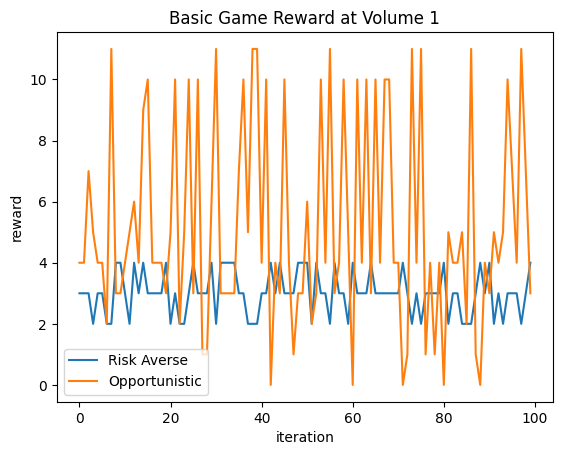

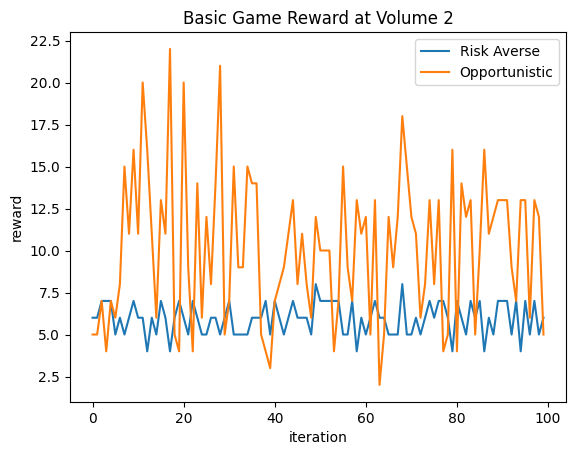

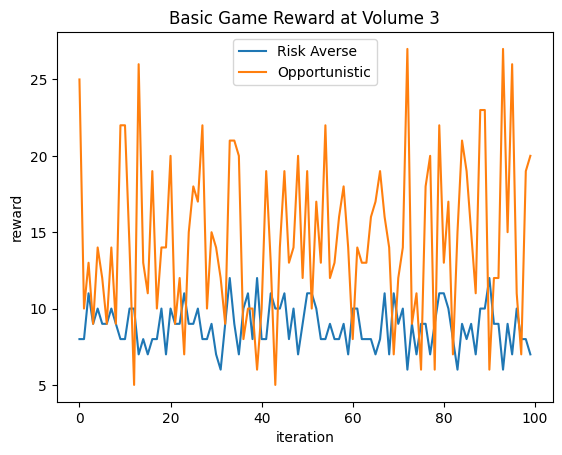

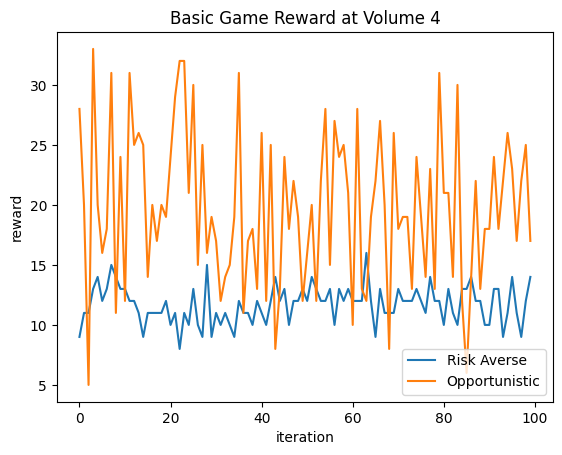

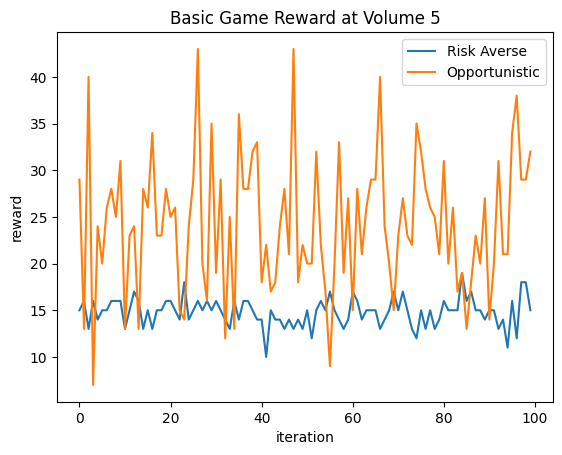

In [51]:
import random
import matplotlib.pyplot as plt
import numpy as np

tasks = {
    "easy": {"probability": 1.0, "payoff": 1},
    "medium": {"probability": 0.7, "payoff": 3},
    "hard": {"probability": 0.3, "payoff": 6}
}

game_configs = {
    "basic": {"easy": 4, "medium": 1, "hard": 1},
    "intermediate": {"easy": 2, "medium": 2, "hard": 2},
    "hard": {"easy": 1, "medium": 1, "hard": 4}
}

def generate_tasks(game_type, volume_level):
    config = game_configs[game_type]
    task_list = []
    for task_type, count in config.items():
        task_list.extend([task_type] * count * volume_level)
    random.shuffle(task_list)
    return task_list

def simulate_game(task_list, strategy_func_1, strategy_func_2):
    scores = [0, 0]
    remaining_tasks = task_list.copy()
    action_history = {1: [], 2: []}

    while remaining_tasks:
        chosen_tasks = [strategy_func_1(remaining_tasks, scores[0]),
                        strategy_func_2(remaining_tasks, scores[1])]

        if chosen_tasks[0] == chosen_tasks[1] and chosen_tasks[0] is not None:
            winner = random.choice([0, 1])
            other = 1 - winner
            success = random.random() <= tasks[chosen_tasks[winner]]["probability"]
            scores[winner] += tasks[chosen_tasks[winner]]["payoff"] if success else 0
            action_history[winner + 1].append((chosen_tasks[winner], 'Success' if success else 'Failure'))
            action_history[other + 1].append((chosen_tasks[other], 'Conflict'))
            remaining_tasks.remove(chosen_tasks[winner])
        else:
            for player_id, task in enumerate(chosen_tasks):
                if task is not None and task in remaining_tasks:
                    success = random.random() <= tasks[task]["probability"]
                    scores[player_id] += tasks[task]["payoff"] if success else 0
                    action_history[player_id + 1].append((task, 'Success' if success else 'Failure'))
                    remaining_tasks.remove(task)

    return scores, action_history

def risk_averse(available_tasks, current_score):
    if not available_tasks:
        return None
    max_prob_task = max(available_tasks, key=lambda task: tasks[task]["probability"])
    return max_prob_task

def opportunistic_strategy(available_tasks, current_score):
    if not available_tasks:
        return None
    max_payoff_task = max(available_tasks, key=lambda task: tasks[task]["payoff"])
    return max_payoff_task

def random_strategy(available_tasks, current_score):
    if not available_tasks:
        return None
    if random.choice([True, False]):
        return random.choice(available_tasks)
    return None

def run_game(agents, strategies, mode, volume, iteration=100):
    scores_1 = []
    scores_2 = []
    for _ in range(iteration):
        tasks = generate_tasks(mode, volume)
        score, _ = simulate_game(tasks, agents[0], agents[1])
        scores_1.append(score[0])
        scores_2.append(score[1])
    plt.plot(scores_1, label=strategies[0])
    plt.plot(scores_2, label=strategies[1])
    plt.legend()
    plt.title(mode.capitalize() + " Game Reward at Volume " + str(volume))
    plt.xlabel("iteration")
    plt.ylabel("reward")
    plt.show()

agents = [risk_averse, opportunistic_strategy]
strategies = ["Risk Averse", "Opportunistic"]

for i in np.arange(1,6):
    run_game(agents, strategies, "basic", i)

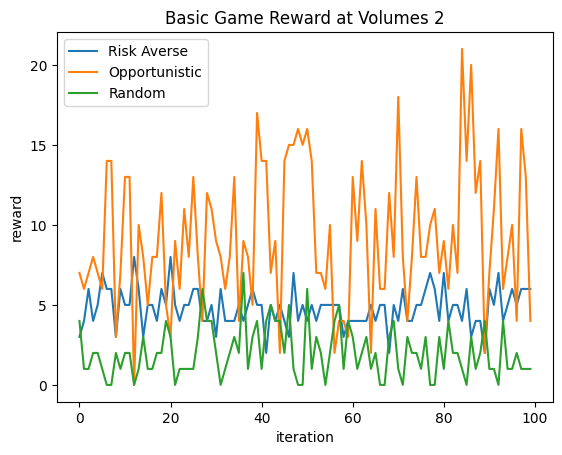

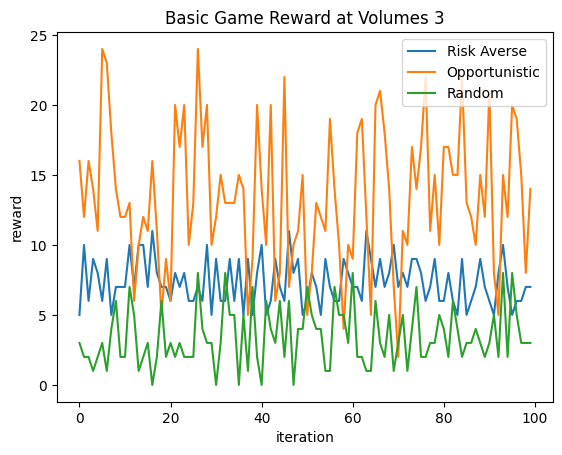

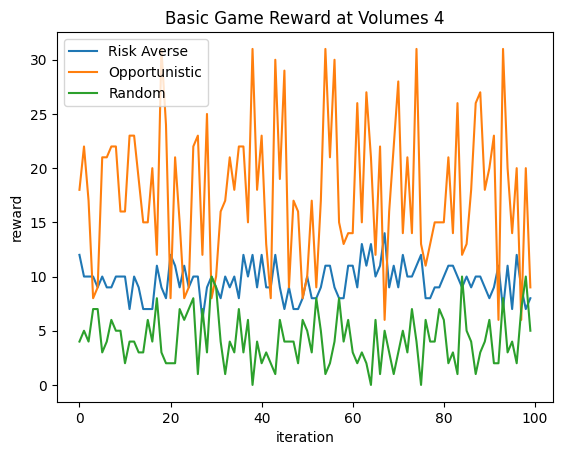

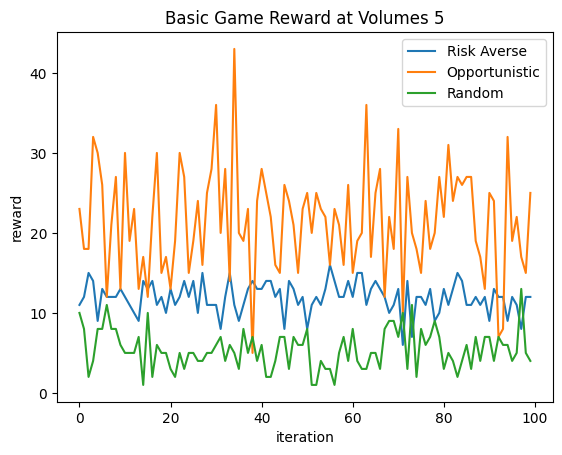

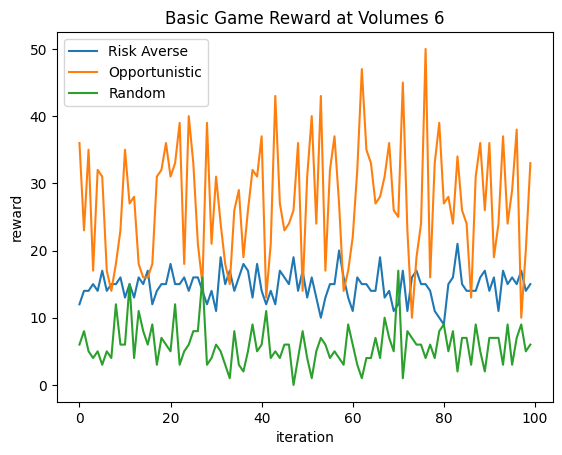

In [54]:
import random
import matplotlib.pyplot as plt
import numpy as np

tasks = {
    "easy": {"probability": 1.0, "payoff": 1},
    "medium": {"probability": 0.7, "payoff": 3},
    "hard": {"probability": 0.3, "payoff": 6}
}

game_configs = {
    "basic": {"easy": 4, "medium": 1, "hard": 1},
    "intermediate": {"easy": 2, "medium": 2, "hard": 2},
    "hard": {"easy": 1, "medium": 1, "hard": 4}
}

def generate_tasks(game_type, volume_level):
    config = game_configs[game_type]
    task_list = []
    for task_type, count in config.items():
        task_list.extend([task_type] * count * volume_level)
    random.shuffle(task_list)
    return task_list

def simulate_game(task_list, *strategy_funcs):
    num_players = len(strategy_funcs)
    scores = [0] * num_players
    remaining_tasks = task_list.copy()
    action_history = {player_id: [] for player_id in range(1, num_players + 1)}

    while remaining_tasks:
        chosen_tasks = [strategy(remaining_tasks, scores[player_id])
                        for player_id, strategy in enumerate(strategy_funcs)]

        unique_tasks = set(chosen_tasks)  # To efficiently check for conflicts

        for task in unique_tasks:
            if task is None or task not in remaining_tasks:
                continue

            players_choosing_task = [i for i, chosen_task in enumerate(chosen_tasks) if chosen_task == task]

            if len(players_choosing_task) > 1:  # Conflict, resolve by random choice
                winner = random.choice(players_choosing_task)
                success = random.random() <= tasks[task]["probability"]
                scores[winner] += tasks[task]["payoff"] if success else 0
                action_history[winner + 1].append((task, 'Success' if success else 'Failure'))
                for player in players_choosing_task:
                    if player != winner:
                        action_history[player + 1].append((task, 'Conflict'))
            else:  # No conflict, player attempts the task
                player = players_choosing_task[0]
                success = random.random() <= tasks[task]["probability"]
                scores[player] += tasks[task]["payoff"] if success else 0
                action_history[player + 1].append((task, 'Success' if success else 'Failure'))

            remaining_tasks.remove(task)

    return scores, action_history

def risk_averse(available_tasks, current_score):
    if not available_tasks:
        return None
    max_prob_task = max(available_tasks, key=lambda task: tasks[task]["probability"])
    return max_prob_task

def opportunistic_strategy(available_tasks, current_score):
    if not available_tasks:
        return None
    max_payoff_task = max(available_tasks, key=lambda task: tasks[task]["payoff"])
    return max_payoff_task

def random_strategy(available_tasks, current_score):
    if not available_tasks:
        return None
    if random.choice([True, False]):
        return random.choice(available_tasks)
    return None

def run_game(agents, strategies, volume, mode, iteration=100):
    num_players = len(agents)
    scores = [[] for _ in range(num_players)]
    # volume_range = [num_players - 1, num_players + 3]

    for _ in range(iteration):
        tasks = generate_tasks(mode, volume)
        score, _ = simulate_game(tasks, *agents)
        for i in range(num_players):
            scores[i].append(score[i])

    # Plotting
    for i, player_scores in enumerate(scores):
        plt.plot(player_scores, label=strategies[i])
    plt.legend()
    plt.title(f"{mode.capitalize()} Game Reward at Volumes {volume}")
    plt.xlabel("iteration")
    plt.ylabel("reward")
    plt.show()

agents = [risk_averse, opportunistic_strategy, random_strategy]
strategies = ["Risk Averse", "Opportunistic", "Random"]
k = len(agents)
for i in np.arange(k-1, k+4):
    run_game(agents, strategies, i, "basic")

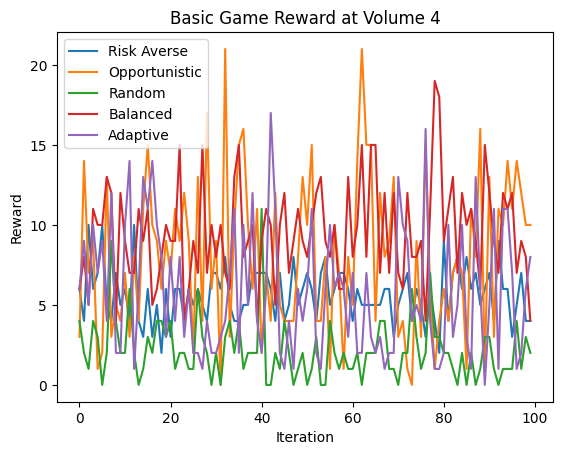

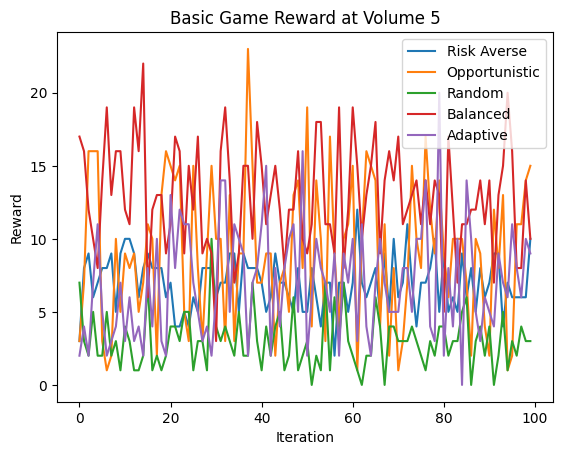

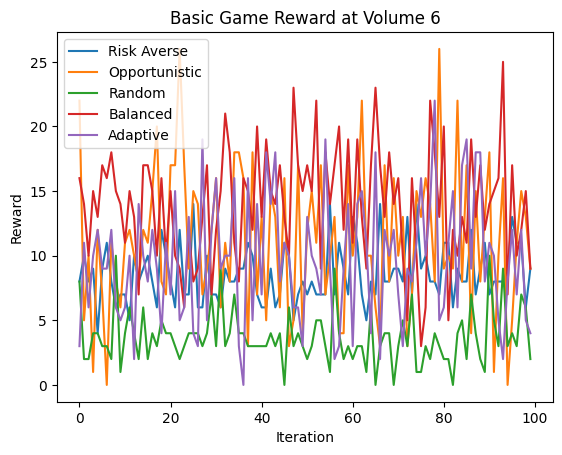

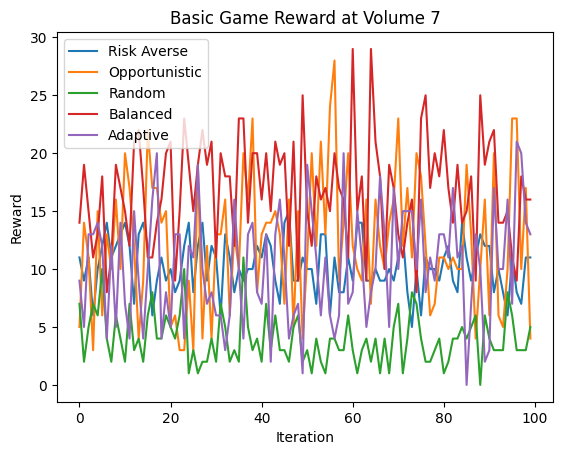

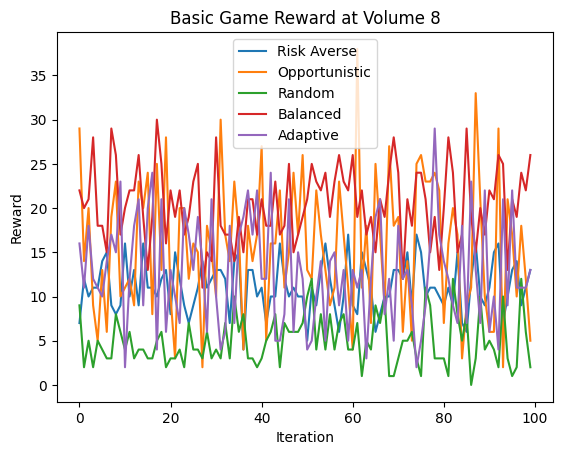

In [55]:
import random
import matplotlib.pyplot as plt
import numpy as np

tasks = {
    "easy": {"probability": 1.0, "payoff": 1},
    "medium": {"probability": 0.7, "payoff": 3},
    "hard": {"probability": 0.3, "payoff": 6}
}

game_configs = {
    "basic": {"easy": 4, "medium": 1, "hard": 1},
    "intermediate": {"easy": 2, "medium": 2, "hard": 2},
    "hard": {"easy": 1, "medium": 1, "hard": 4}
}

def generate_tasks(game_type, volume_level):
    config = game_configs[game_type]
    task_list = []
    for task_type, count in config.items():
        task_list.extend([task_type] * count * volume_level)
    random.shuffle(task_list)
    return task_list

def simulate_game(task_list, *strategy_funcs):
    num_players = len(strategy_funcs)
    scores = [0] * num_players
    remaining_tasks = task_list.copy()
    action_history = {player_id: [] for player_id in range(1, num_players + 1)}

    while remaining_tasks:
        # Get the list of opponent scores for each player
        opponent_scores = [[scores[j] for j in range(num_players) if j != i] for i in range(num_players)]
        chosen_tasks = [strategy(remaining_tasks, scores[player_id], opponent_scores[player_id])
                        if strategy.__name__ == "adaptive_strategy"
                        else strategy(remaining_tasks, scores[player_id])
                        for player_id, strategy in enumerate(strategy_funcs)]

        unique_tasks = set(chosen_tasks)  # To efficiently check for conflicts

        for task in unique_tasks:
            if task is None or task not in remaining_tasks:
                continue

            players_choosing_task = [i for i, chosen_task in enumerate(chosen_tasks) if chosen_task == task]

            if len(players_choosing_task) > 1:  # Conflict, resolve by random choice
                winner = random.choice(players_choosing_task)
                success = random.random() <= tasks[task]["probability"]
                scores[winner] += tasks[task]["payoff"] if success else 0
                action_history[winner + 1].append((task, 'Success' if success else 'Failure'))
                for player in players_choosing_task:
                    if player != winner:
                        action_history[player + 1].append((task, 'Conflict'))
            else:  # No conflict, player attempts the task
                player = players_choosing_task[0]
                success = random.random() <= tasks[task]["probability"]
                scores[player] += tasks[task]["payoff"] if success else 0
                action_history[player + 1].append((task, 'Success' if success else 'Failure'))

            remaining_tasks.remove(task)

    return scores, action_history

def risk_averse(available_tasks, current_score):
    if not available_tasks:
        return None
    max_prob_task = max(available_tasks, key=lambda task: tasks[task]["probability"])
    return max_prob_task

def opportunistic_strategy(available_tasks, current_score):
    if not available_tasks:
        return None
    max_payoff_task = max(available_tasks, key=lambda task: tasks[task]["payoff"])
    return max_payoff_task

def random_strategy(available_tasks, current_score):
    if not available_tasks:
        return None
    if random.choice([True, False]):
        return random.choice(available_tasks)
    return None

def balanced_strategy(available_tasks, current_score):
    if not available_tasks:
        return None
    # Balance the task choice by considering both the payoff and the probability.
    best_task = max(available_tasks, key=lambda task: tasks[task]["probability"] * tasks[task]["payoff"])
    return best_task

def adaptive_strategy(available_tasks, current_score, opponent_scores):
    if not available_tasks:
        return None

    # If ahead, prefer tasks with higher probability (risk-averse)
    if current_score > max(opponent_scores):
        return risk_averse(available_tasks, current_score)
    # If behind, prefer tasks with higher payoff (opportunistic)
    elif current_score < max(opponent_scores):
        return opportunistic_strategy(available_tasks, current_score)
    # If tied, go for the balanced approach
    else:
        return balanced_strategy(available_tasks, current_score)


def run_game(agents, strategies, volume, mode, iteration=100):
    num_players = len(agents)
    scores = [[] for _ in range(num_players)]

    for _ in range(iteration):
        tasks = generate_tasks(mode, volume)
        score, _ = simulate_game(tasks, *agents)
        for i in range(num_players):
            scores[i].append(score[i])

    # Plotting
    for i, player_scores in enumerate(scores):
        plt.plot(player_scores, label=strategies[i])
    plt.legend()
    plt.title(f"{mode.capitalize()} Game Reward at Volume {volume}")
    plt.xlabel("Iteration")
    plt.ylabel("Reward")
    plt.show()
    
agents = [risk_averse, opportunistic_strategy, random_strategy, balanced_strategy, adaptive_strategy]
strategies = ["Risk Averse", "Opportunistic", "Random", "Balanced", "Adaptive"]

k = len(agents)
for i in np.arange(k-1, k+4):
    run_game(agents, strategies, i, "basic")

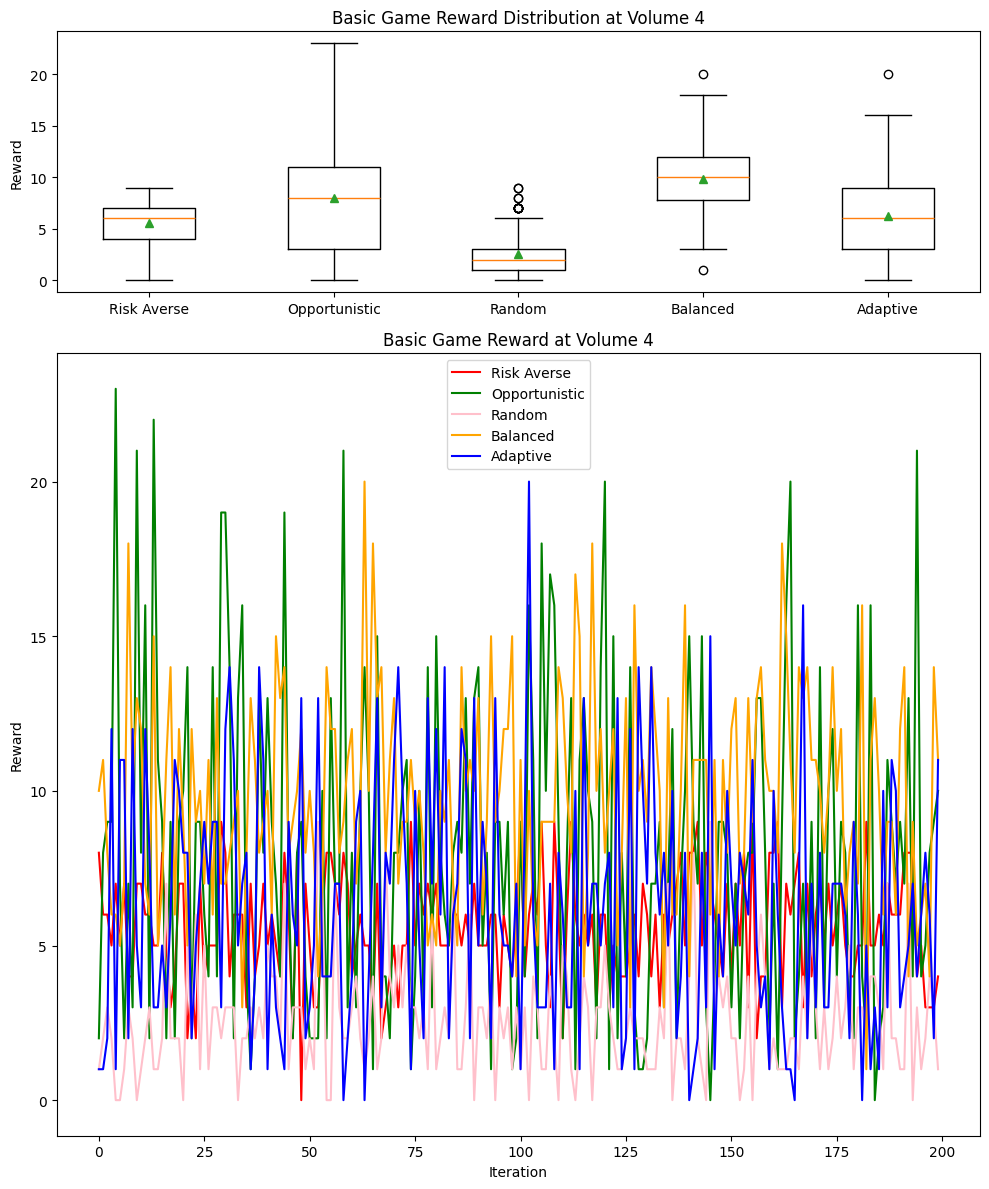

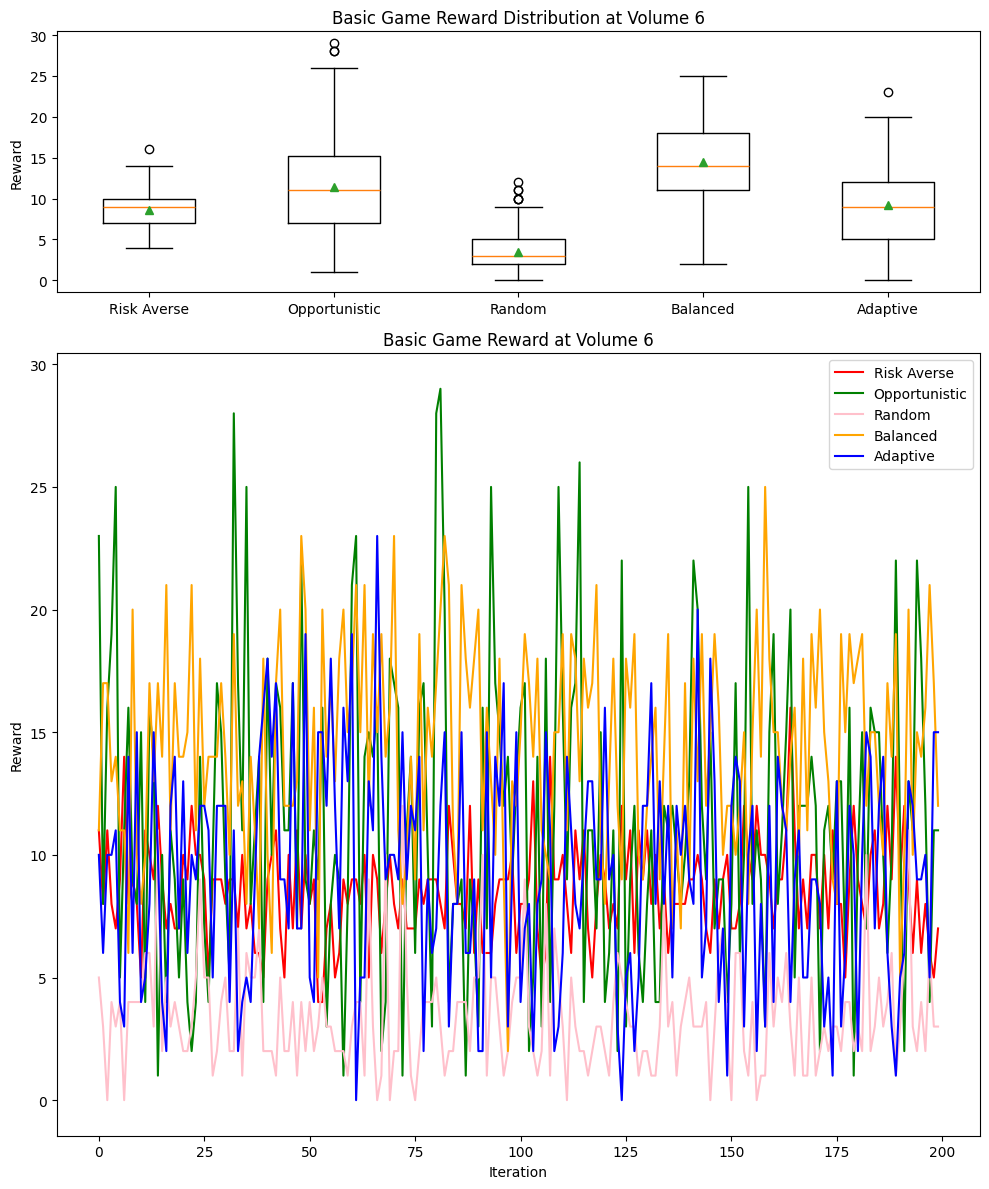

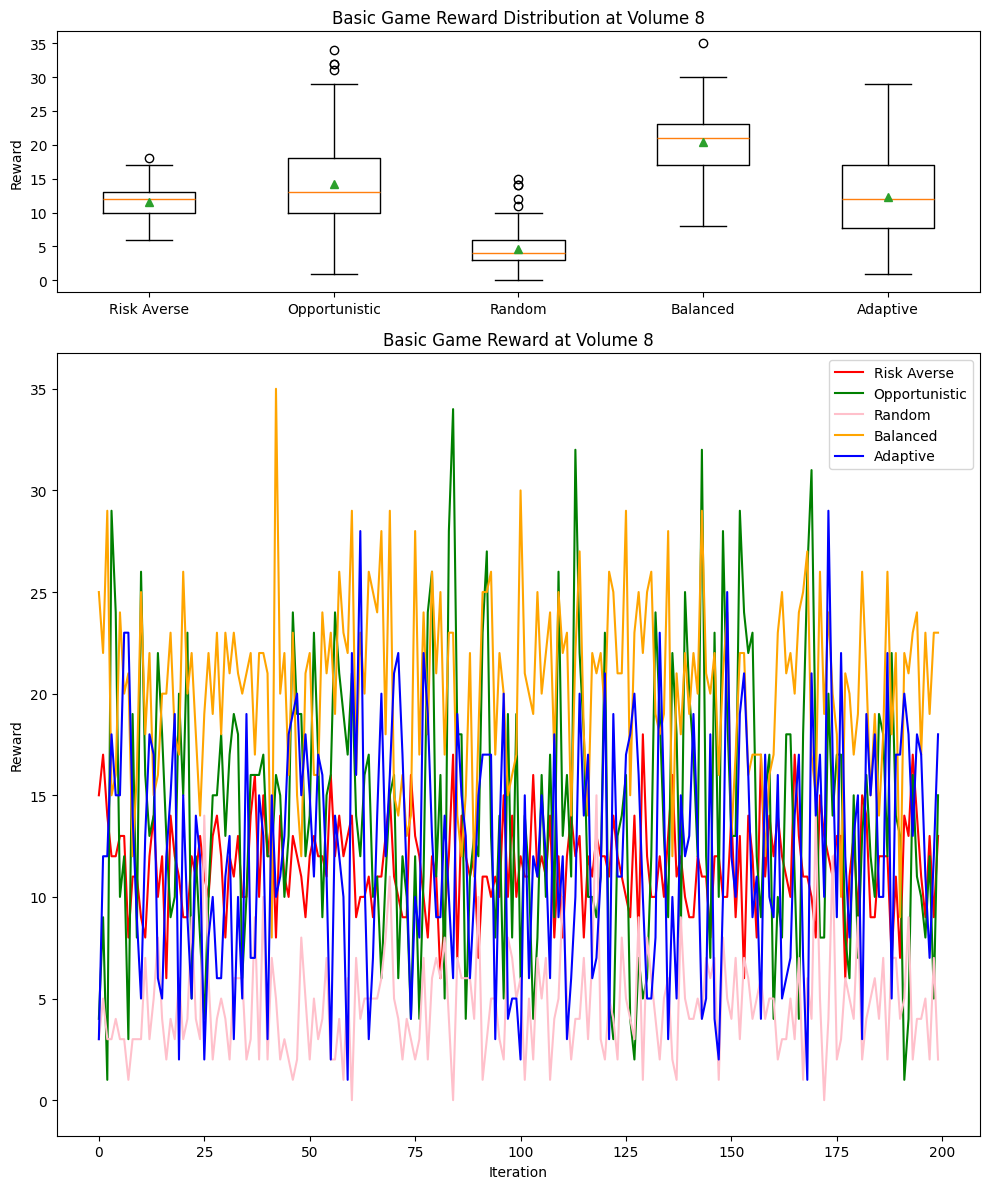

In [64]:
import random
import matplotlib.pyplot as plt
import numpy as np

tasks = {
    "easy": {"probability": 1.0, "payoff": 1},
    "medium": {"probability": 0.7, "payoff": 3},
    "hard": {"probability": 0.3, "payoff": 6}
}

game_configs = {
    "basic": {"easy": 4, "medium": 1, "hard": 1},
    "intermediate": {"easy": 2, "medium": 2, "hard": 2},
    "hard": {"easy": 1, "medium": 1, "hard": 4}
}

def generate_tasks(game_type, volume_level):
    config = game_configs[game_type]
    task_list = []
    for task_type, count in config.items():
        task_list.extend([task_type] * count * volume_level)
    random.shuffle(task_list)
    return task_list

def simulate_game(task_list, *strategy_funcs):
    num_players = len(strategy_funcs)
    scores = [0] * num_players
    remaining_tasks = task_list.copy()
    action_history = {player_id: [] for player_id in range(1, num_players + 1)}

    while remaining_tasks:
        # Get the list of opponent scores for each player
        opponent_scores = [[scores[j] for j in range(num_players) if j != i] for i in range(num_players)]
        chosen_tasks = [strategy(remaining_tasks, scores[player_id], opponent_scores[player_id])
                        if strategy.__name__ == "adaptive_strategy"
                        else strategy(remaining_tasks, scores[player_id])
                        for player_id, strategy in enumerate(strategy_funcs)]

        unique_tasks = set(chosen_tasks)  # To efficiently check for conflicts

        for task in unique_tasks:
            if task is None or task not in remaining_tasks:
                continue

            players_choosing_task = [i for i, chosen_task in enumerate(chosen_tasks) if chosen_task == task]

            if len(players_choosing_task) > 1:  # Conflict, resolve by random choice
                winner = random.choice(players_choosing_task)
                success = random.random() <= tasks[task]["probability"]
                scores[winner] += tasks[task]["payoff"] if success else 0
                action_history[winner + 1].append((task, 'Success' if success else 'Failure'))
                for player in players_choosing_task:
                    if player != winner:
                        action_history[player + 1].append((task, 'Conflict'))
            else:  # No conflict, player attempts the task
                player = players_choosing_task[0]
                success = random.random() <= tasks[task]["probability"]
                scores[player] += tasks[task]["payoff"] if success else 0
                action_history[player + 1].append((task, 'Success' if success else 'Failure'))

            remaining_tasks.remove(task)

    return scores, action_history

def risk_averse(available_tasks, current_score):
    if not available_tasks:
        return None
    max_prob_task = max(available_tasks, key=lambda task: tasks[task]["probability"])
    return max_prob_task

def opportunistic_strategy(available_tasks, current_score):
    if not available_tasks:
        return None
    max_payoff_task = max(available_tasks, key=lambda task: tasks[task]["payoff"])
    return max_payoff_task

def random_strategy(available_tasks, current_score):
    if not available_tasks:
        return None
    if random.choice([True, False]):
        return random.choice(available_tasks)
    return None

def balanced_strategy(available_tasks, current_score):
    if not available_tasks:
        return None
    # Balance the task choice by considering both the payoff and the probability.
    best_task = max(available_tasks, key=lambda task: tasks[task]["probability"] * tasks[task]["payoff"])
    return best_task

def adaptive_strategy(available_tasks, current_score, opponent_scores):
    if not available_tasks:
        return None

    # If ahead, prefer tasks with higher probability (risk-averse)
    if current_score > max(opponent_scores):
        return risk_averse(available_tasks, current_score)
    # If behind, prefer tasks with higher payoff (opportunistic)
    elif current_score < max(opponent_scores):
        return opportunistic_strategy(available_tasks, current_score)
    # If tied, go for the balanced approach
    else:
        return balanced_strategy(available_tasks, current_score)

def run_game(agents, strategies, colors, volume, mode, iteration=200):
    num_players = len(agents)
    all_scores = [[] for _ in range(num_players)]

    for _ in range(iteration):
        tasks = generate_tasks(mode, volume)
        score, _ = simulate_game(tasks, *agents)
        for i in range(num_players):
            all_scores[i].append(score[i])

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 12), gridspec_kw={'height_ratios': [1, 3]})
    
    # Boxplot
    axs[0].boxplot(all_scores, labels=strategies, showmeans=True)
    axs[0].set_title(f"{mode.capitalize()} Game Reward Distribution at Volume {volume}")
    axs[0].set_ylabel("Reward")
    
    # Line plot
    for i, player_scores in enumerate(all_scores):
        axs[1].plot(player_scores, label=strategies[i], color = colors[i])
    axs[1].legend()
    axs[1].set_title(f"{mode.capitalize()} Game Reward at Volume {volume}")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("Reward")
    
    plt.tight_layout()
    plt.show()
    
agents = [risk_averse, opportunistic_strategy, random_strategy, balanced_strategy, adaptive_strategy]
strategies = ["Risk Averse", "Opportunistic", "Random", "Balanced", "Adaptive"]
colors = ["red", "green", "pink", "orange", "blue"]

k = len(agents)
for i in np.arange(k-1, k+4, 2):
    run_game(agents, strategies, colors, i, "basic")